In [40]:
# Core libraries
import pandas as pd
import numpy as np
import sqlite3
import os

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning (we’ll use later)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Change to project root (adjust as needed)
os.chdir("C:/Projects/Emissions_Analysis_Capstone")

In [41]:
# File paths
livestock_path = "raw_data/GLEAM_LivestockEmissions.csv"
vehicle_path = "raw_data/vehicle_emission_dataset.csv"

# Load CSVs
livestock_df = pd.read_csv(livestock_path)
vehicle_df = pd.read_csv(vehicle_path)

# Preview data
print("Livestock dataset shape:", livestock_df.shape)
display(livestock_df.head())

print("Vehicle dataset shape:", vehicle_df.shape)
display(vehicle_df.head())

Livestock dataset shape: (583, 22)


,Region,Animal species,Production system,Commodity,Emission Intensity (kg CO2e per kg protein),Production (kg protein),Total GHG emissions (kg CO2e),Total CO2 emissions (kg CO2e),Total CH4 emissions (kg CO2e),Total N2O emissions (kg CO2e),...,"Feed: fertilizer & crop residues, N2O (kg CO2e)","Feed: applied & deposited manure, N2O (kg CO2e)","LUC: soy & palm, CO2 (kg CO2e)","LUC: pasture expansion, CO2 (kg CO2e)","Enteric fermentation, CH4 (kg CO2e)","Manure management, CH4 (kg CO2e)","Manure management, N2O (kg CO2e)","Direct energy, CO2 (kg CO2e)","Indirect energy, CO2 (kg CO2e)","Postfarm, CO2 (kg CO2e)"
0,Global,Cattle,Aggregated,Aggregated,160.3,2.916310e+10,4.674630e+12,9.449299e+11,2.648727e+12,1.080973e+12,...,1.740732e+11,7.419864e+11,4.687954e+10,3.870062e+11,2.509275e+12,1.394522e+11,1.649130e+11,4.215542e+10,1.585653e+10,9.955932e+10
1,Global,Cattle,Aggregated,Milk,86.7,1.888089e+10,1.637519e+12,2.756914e+11,9.676442e+11,3.941834e+11,...,7.166208e+10,2.543885e+11,1.497421e+10,NaN,8.856352e+11,8.200906e+10,6.813278e+10,2.993485e+10,3.252889e+09,8.929544e+10
2,Global,Cattle,Aggregated,Meat,295.4,1.028222e+10,3.037111e+12,6.692385e+11,1.681083e+12,6.867892e+11,...,1.024111e+11,4.875979e+11,3.190534e+10,3.870062e+11,1.623640e+12,5.744310e+10,9.678019e+10,1.222057e+10,1.260364e+10,1.026388e+10
3,Global,Cattle,Grassland systems,Aggregated,206.3,1.033817e+10,2.133054e+12,5.628062e+11,1.052965e+12,5.172829e+11,...,5.253660e+10,4.267612e+11,8.194330e+09,3.870062e+11,9.969096e+11,5.605552e+10,3.798508e+10,1.417326e+10,4.303272e+09,3.773092e+10
4,Global,Cattle,Grassland systems,Milk,95.0,6.940654e+09,6.592844e+11,9.286140e+10,3.713461e+11,1.950770e+11,...,2.156126e+10,1.587838e+11,2.412100e+09,NaN,3.369018e+11,3.444428e+10,1.473188e+10,1.078605e+10,9.998435e+08,3.462338e+10


Vehicle dataset shape: (10000, 19)


,Vehicle Type,Fuel Type,Engine Size,Age of Vehicle,Mileage,Speed,Acceleration,Road Type,Traffic Conditions,Temperature,Humidity,Wind Speed,Air Pressure,CO2 Emissions,NOx Emissions,PM2.5 Emissions,VOC Emissions,SO2 Emissions,Emission Level
0,Motorcycle,Electric,2.747609,22,291288,49.083255,1.887738,Highway,Moderate,13.880458,52.883905,18.938861,955.411642,179.930088,1.085520,0.011548,0.096207,0.022936,Medium
1,Bus,Electric,5.743714,3,188398,23.460311,3.544147,City,Heavy,19.136947,5.697343,14.716526,1035.763062,250.505219,1.285628,0.187112,0.073321,0.028021,Medium
2,Bus,Hybrid,4.606368,17,281451,115.508350,4.646886,Highway,Free flow,8.123428,3.953116,18.644522,976.207064,404.979103,0.258189,0.132398,0.014744,0.075334,High
3,Truck,Electric,3.913024,4,151321,18.540217,3.581004,Rural,Heavy,35.994893,0.509678,11.951859,966.919462,463.568608,1.040956,0.166325,0.093490,0.025324,High
4,Truck,Hybrid,1.611297,15,91810,109.596566,3.879303,Highway,Moderate,14.793481,52.450884,2.761138,953.229351,79.514604,1.583390,0.078043,0.020396,0.024986,Low


In [42]:
# Drop duplicate rows
livestock_df.drop_duplicates(inplace=True)
vehicle_df.drop_duplicates(inplace=True)

# Handle missing values (basic strategy — we’ll refine later)
livestock_df.fillna(0, inplace=True)
vehicle_df.fillna(0, inplace=True)

# Optionally rename columns for clarity
livestock_df.rename(columns=lambda x: x.strip().lower().replace(' ', '_'), inplace=True)
vehicle_df.rename(columns=lambda x: x.strip().lower().replace(' ', '_'), inplace=True)

In [43]:
# Define database path
db_path = os.path.join('emissions_data', 'emissionsdata.sqlite')

# Ensure the database folder exists
os.makedirs(os.path.dirname(db_path), exist_ok=True)

# Connect to SQLite
conn = sqlite3.connect(db_path)


# --- Clean column names for both CSVs ---
# Standardize: lowercase, underscores, remove special characters
def clean_columns(df):
    df.columns = (
        df.columns.str.strip()
        .str.lower()
        .str.replace(' ', '_')
        .str.replace('[^a-z0-9_]', '', regex=True)
    )
    return df


livestock_df = clean_columns(livestock_df)
vehicle_df = clean_columns(vehicle_df)

# --- Select only desired columns ---
livestock_subset = livestock_df[
    [
        'region',
        'animal_species',
        'production_system',
        'commodity',
        'total_co2_emissions_kg_co2e',
        'total_n2o_emissions_kg_co2e',
    ]
].copy()

# Optional: rename for consistent database naming
livestock_subset.rename(
    columns={
        'animal_species': 'animal_type',
        'production_system': 'production_system',
        'commodity': 'commodity',
        'total_co2_emissions_kg_co2e': 'co2_emissions_kg',
        'total_n2o_emissions_kg_co2e': 'n2o_emissions_kg',
    },
    inplace=True,
)

vehicle_subset = vehicle_df[
    ['vehicle_type', 'fuel_type', 'age_of_vehicle', 'co2_emissions', 'nox_emissions']
].copy()

vehicle_subset.rename(
    columns={
        'age_of_vehicle': 'vehicle_age',
        'co2_emissions': 'co2_emissions_g_per_km',
        'nox_emissions': 'nox_emissions_g_per_km',
    },
    inplace=True,
)

# --- Write to SQLite ---
livestock_subset.to_sql('livestock_emissions', conn, if_exists='replace', index=False)
vehicle_subset.to_sql('vehicle_emissions', conn, if_exists='replace', index=False)

# --- Verify tables ---
print(pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn))

# Preview first few rows
print("\nLivestock sample:")
print(pd.read_sql("SELECT * FROM livestock_emissions LIMIT 5;", conn))

print("\nVehicle sample:")
print(pd.read_sql("SELECT * FROM vehicle_emissions LIMIT 5;", conn))

#conn.close()

                  name
0  livestock_emissions
1    vehicle_emissions

Livestock sample:
   region animal_type  production_system   commodity  co2_emissions_kg  \
0  Global      Cattle         Aggregated  Aggregated      9.449299e+11   
1  Global      Cattle         Aggregated        Milk      2.756914e+11   
2  Global      Cattle         Aggregated        Meat      6.692385e+11   
3  Global      Cattle  Grassland systems  Aggregated      5.628062e+11   
4  Global      Cattle  Grassland systems        Milk      9.286140e+10   

   n2o_emissions_kg  
0      1.080973e+12  
1      3.941834e+11  
2      6.867892e+11  
3      5.172829e+11  
4      1.950770e+11  

Vehicle sample:
  vehicle_type fuel_type  vehicle_age  co2_emissions_g_per_km  \
0   Motorcycle  Electric           22              179.930088   
1          Bus  Electric            3              250.505219   
2          Bus    Hybrid           17              404.979103   
3        Truck  Electric            4              463.568

In [50]:
print("Livestock columns:", livestock_df.columns.tolist())
print("Vehicle columns:", vehicle_df.columns.tolist())

Livestock columns: ['region', 'animal_species', 'production_system', 'commodity', 'emission_intensity_kg_co2e_per_kg_protein', 'production_kg_protein', 'total_ghg_emissions_kg_co2e', 'total_co2_emissions_kg_co2e', 'total_ch4_emissions_kg_co2e', 'total_n2o_emissions_kg_co2e', 'feed_co2_kg_co2e', 'feed_ch4_kg_co2e', 'feed_fertilizer__crop_residues_n2o_kg_co2e', 'feed_applied__deposited_manure_n2o_kg_co2e', 'luc_soy__palm_co2_kg_co2e', 'luc_pasture_expansion_co2_kg_co2e', 'enteric_fermentation_ch4_kg_co2e', 'manure_management_ch4_kg_co2e', 'manure_management_n2o_kg_co2e', 'direct_energy_co2_kg_co2e', 'indirect_energy_co2_kg_co2e', 'postfarm_co2_kg_co2e']
Vehicle columns: ['vehicle_type', 'fuel_type', 'engine_size', 'age_of_vehicle', 'mileage', 'speed', 'acceleration', 'road_type', 'traffic_conditions', 'temperature', 'humidity', 'wind_speed', 'air_pressure', 'co2_emissions', 'nox_emissions', 'pm25_emissions', 'voc_emissions', 'so2_emissions', 'emission_level']


In [45]:
livestock_data = pd.read_sql("SELECT * FROM livestock_emissions", conn)
vehicle_data = pd.read_sql("SELECT * FROM vehicle_emissions", conn)

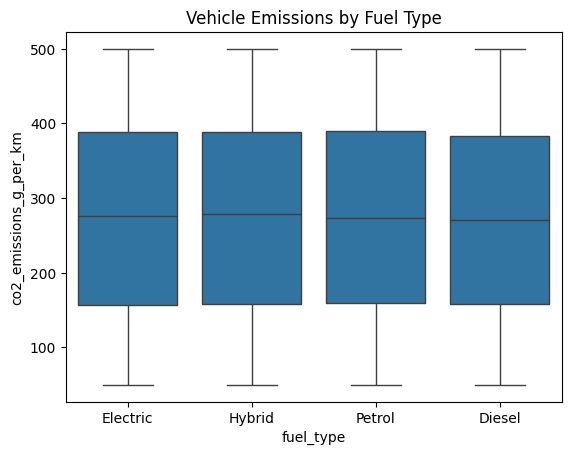

In [46]:
# Simple example visual
sns.boxplot(x='fuel_type', y='co2_emissions_g_per_km', data=vehicle_data)
plt.title("Vehicle Emissions by Fuel Type")
plt.show()

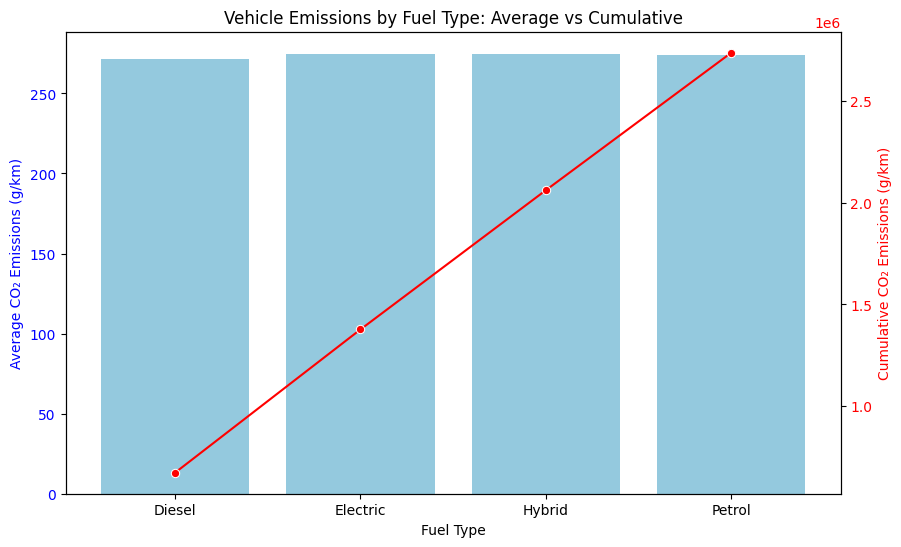

In [49]:
# Calculate average emissions per fuel type
avg_emissions = vehicle_data.groupby('fuel_type')['co2_emissions_g_per_km'].mean().reset_index()
# Calculate cumulative emissions for the line plot
cum_emissions = vehicle_data.groupby('fuel_type')['co2_emissions_g_per_km'].sum().cumsum().reset_index()

fig, ax1 = plt.subplots(figsize=(10,6))

# Bar plot for average emissions
sns.barplot(x='fuel_type', y='co2_emissions_g_per_km', data=avg_emissions, ax=ax1, color='skyblue')
ax1.set_ylabel("Average CO₂ Emissions (g/km)", color='blue')
ax1.set_xlabel("Fuel Type")
ax1.tick_params(axis='y', labelcolor='blue')

# Line plot for cumulative emissions on secondary y-axis
ax2 = ax1.twinx()
sns.lineplot(x='fuel_type', y='co2_emissions_g_per_km', data=cum_emissions, ax=ax2, marker='o', color='red')
ax2.set_ylabel("Cumulative CO₂ Emissions (g/km)", color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title("Vehicle Emissions by Fuel Type: Average vs Cumulative")
plt.show()

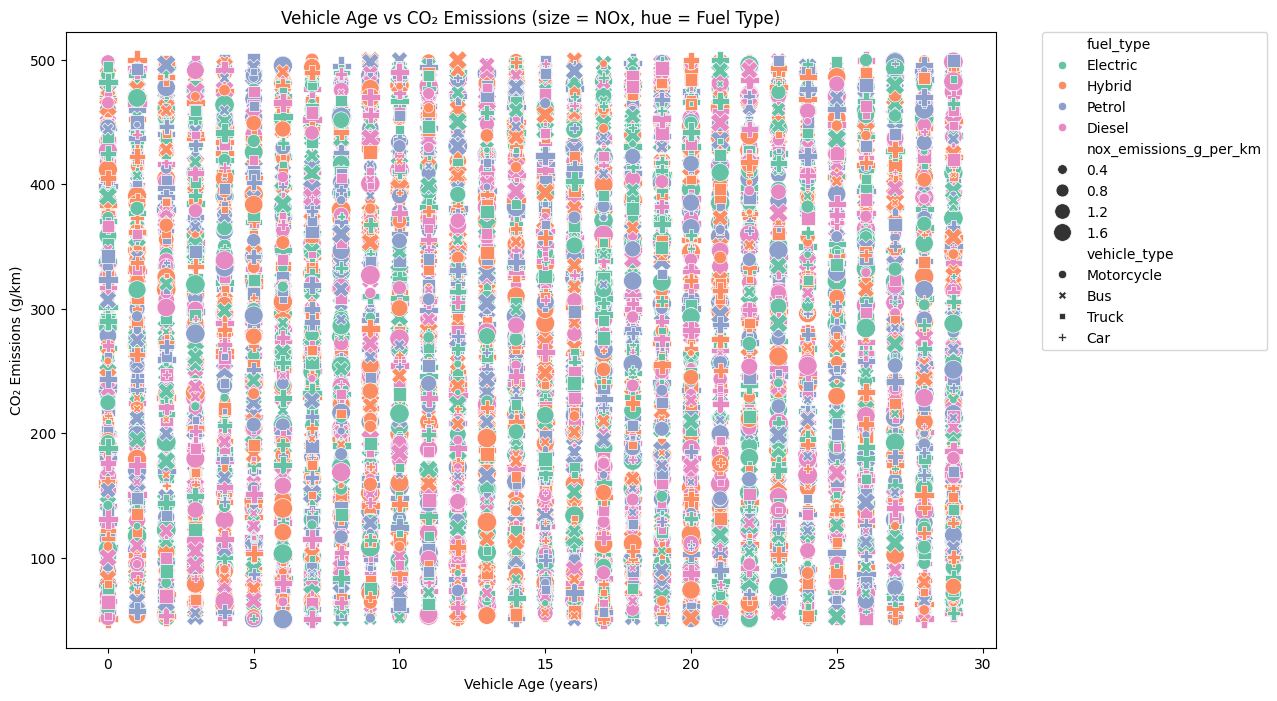

In [51]:
plt.figure(figsize=(12,8))

# Scatter plot:
# x = vehicle_age, y = CO2, size = NOx, color = fuel_type
sns.scatterplot(
    data=vehicle_data,
    x='vehicle_age',
    y='co2_emissions_g_per_km',
    hue='fuel_type',
    style='vehicle_type',
    size='nox_emissions_g_per_km',
    sizes=(20, 200),  # min/max size for points
    palette='Set2'
)

plt.title("Vehicle Age vs CO₂ Emissions (size = NOx, hue = Fuel Type)")
plt.xlabel("Vehicle Age (years)")
plt.ylabel("CO₂ Emissions (g/km)")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

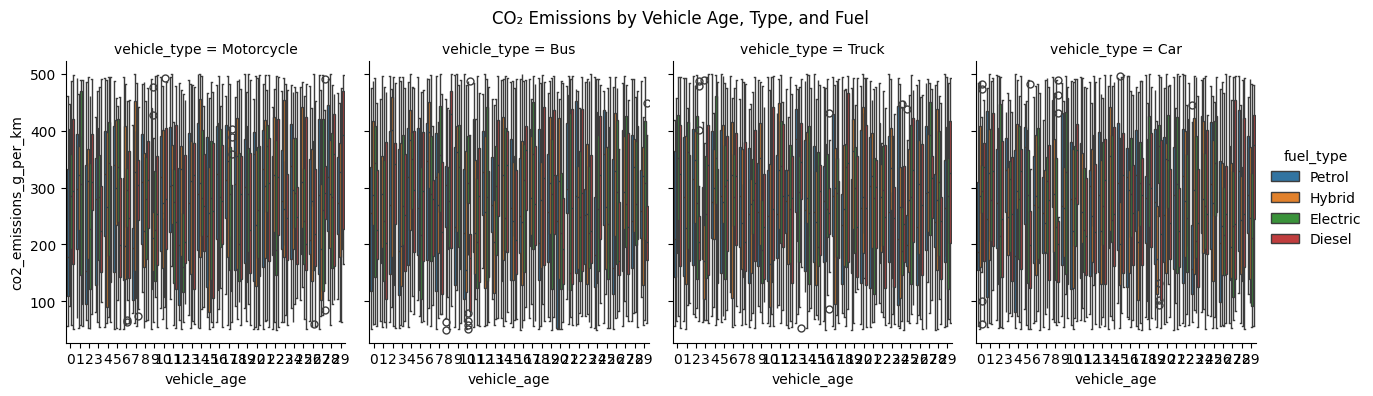

In [52]:
sns.catplot(
    data=vehicle_data,
    x='vehicle_age',
    y='co2_emissions_g_per_km',
    hue='fuel_type',
    col='vehicle_type',
    kind='box',
    height=4,
    aspect=0.8
)
plt.subplots_adjust(top=0.85)
plt.suptitle("CO₂ Emissions by Vehicle Age, Type, and Fuel")
plt.show()

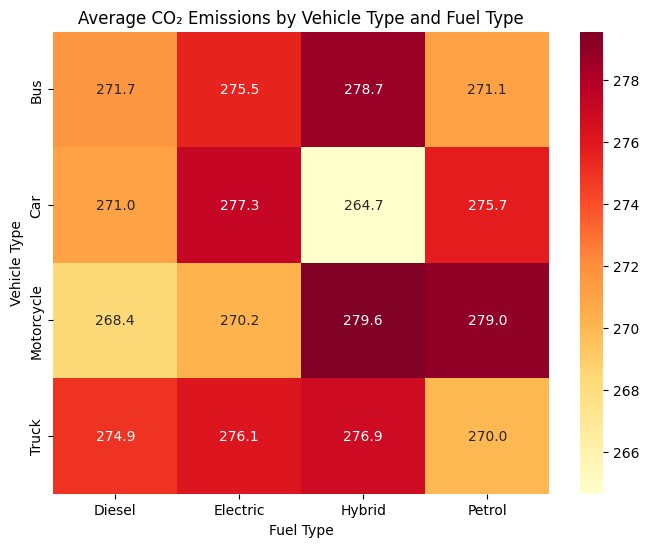

In [53]:
pivot = vehicle_data.pivot_table(
    index='vehicle_type',
    columns='fuel_type',
    values='co2_emissions_g_per_km',
    aggfunc='mean'
)

plt.figure(figsize=(8,6))
sns.heatmap(pivot, annot=True, fmt=".1f", cmap='YlOrRd')
plt.title("Average CO₂ Emissions by Vehicle Type and Fuel Type")
plt.ylabel("Vehicle Type")
plt.xlabel("Fuel Type")
plt.show()

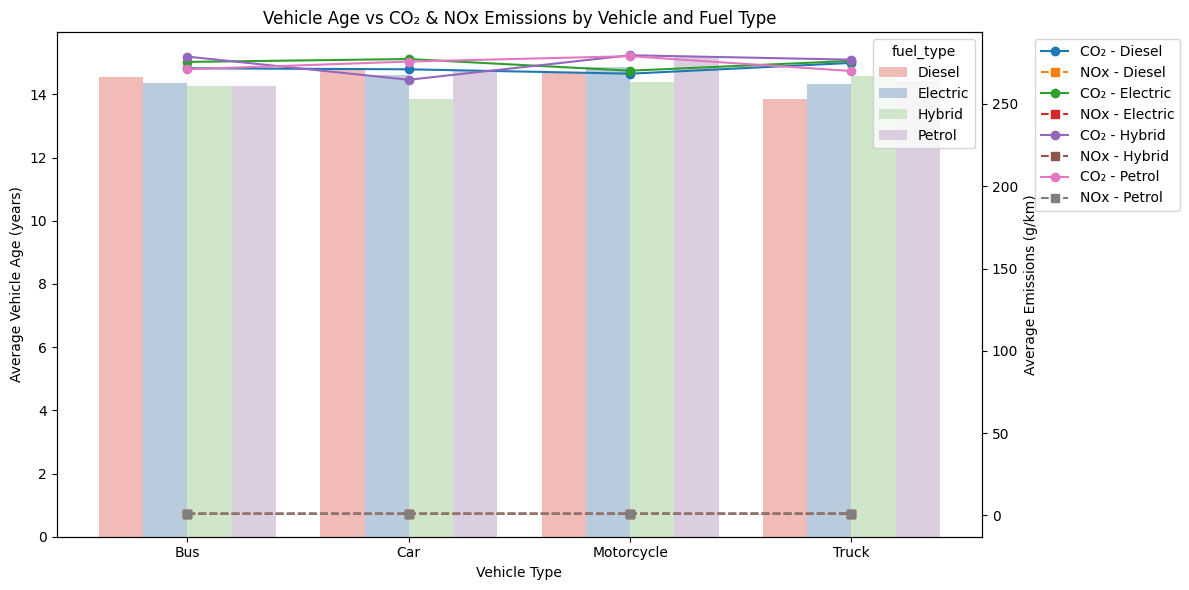

In [54]:
# 1. Aggregate the data
agg_df = vehicle_data.groupby(['vehicle_type', 'fuel_type']).agg(
    avg_age=('vehicle_age', 'mean'),
    avg_co2=('co2_emissions_g_per_km', 'mean'),
    avg_nox=('nox_emissions_g_per_km', 'mean')
).reset_index()

# 2. Create the plot
fig, ax1 = plt.subplots(figsize=(12,6))

# Bar plot: average vehicle age
sns.barplot(
    data=agg_df,
    x='vehicle_type',
    y='avg_age',
    hue='fuel_type',
    ax=ax1,
    palette='Pastel1'
)
ax1.set_ylabel("Average Vehicle Age (years)")
ax1.set_xlabel("Vehicle Type")
ax1.set_title("Vehicle Age vs CO₂ & NOx Emissions by Vehicle and Fuel Type")

# 3. Create secondary axis for emissions
ax2 = ax1.twinx()

# Line plots: CO2 and NOx emissions
for fuel in agg_df['fuel_type'].unique():
    fuel_df = agg_df[agg_df['fuel_type'] == fuel]
    ax2.plot(
        fuel_df['vehicle_type'],
        fuel_df['avg_co2'],
        marker='o',
        linestyle='-',
        label=f'CO₂ - {fuel}'
    )
    ax2.plot(
        fuel_df['vehicle_type'],
        fuel_df['avg_nox'],
        marker='s',
        linestyle='--',
        label=f'NOx - {fuel}'
    )

ax2.set_ylabel("Average Emissions (g/km)")
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


In [55]:
# Aggregate emissions by fuel type
fuel_summary = vehicle_data.groupby('fuel_type').agg(
    avg_co2=('co2_emissions_g_per_km', 'mean'),
    total_co2=('co2_emissions_g_per_km', 'sum'),
    avg_nox=('nox_emissions_g_per_km', 'mean'),
    total_nox=('nox_emissions_g_per_km', 'sum'),
    vehicle_count=('vehicle_type', 'count')
).reset_index()

# Mark Electric vs Non-Electric
fuel_summary['category'] = fuel_summary['fuel_type'].apply(lambda x: 'Electric' if 'Electric' in x else 'Other')

print(fuel_summary)

  fuel_type     avg_co2      total_co2   avg_nox    total_nox  vehicle_count  \
0    Diesel  271.501262  672780.126365  1.030954  2554.703389           2478   
1  Electric  274.792539  704293.276939  1.046536  2682.273003           2563   
2    Hybrid  274.794324  684512.661964  1.039885  2590.354392           2491   
3    Petrol  273.859998  675886.476168  1.057315  2609.453909           2468   

   category  
0     Other  
1  Electric  
2     Other  
3     Other  


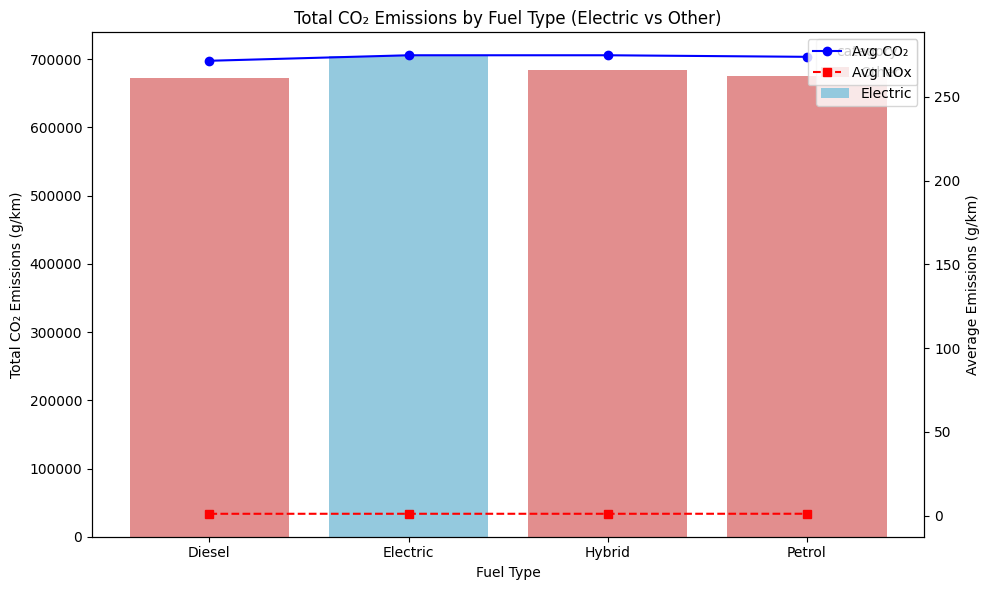

In [56]:
fig, ax1 = plt.subplots(figsize=(10,6))

# Bar: total CO2 emissions
sns.barplot(
    data=fuel_summary,
    x='fuel_type',
    y='total_co2',
    hue='category',
    palette={'Electric':'skyblue', 'Other':'lightcoral'},
    ax=ax1
)
ax1.set_ylabel("Total CO₂ Emissions (g/km)")
ax1.set_xlabel("Fuel Type")
ax1.set_title("Total CO₂ Emissions by Fuel Type (Electric vs Other)")

# Secondary axis: average CO2 and NOx
ax2 = ax1.twinx()
ax2.plot(fuel_summary['fuel_type'], fuel_summary['avg_co2'], marker='o', linestyle='-', color='blue', label='Avg CO₂')
ax2.plot(fuel_summary['fuel_type'], fuel_summary['avg_nox'], marker='s', linestyle='--', color='red', label='Avg NOx')
ax2.set_ylabel("Average Emissions (g/km)")
ax2.legend(loc='upper right')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [48]:
# One-hot encode categorical features
X = pd.get_dummies(vehicle_data[['vehicle_type', 'fuel_type']], drop_first=True)
y = vehicle_data['co2_emissions_g_per_km']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression().fit(X_train, y_train)

preds = model.predict(X_test)

print("R²:", r2_score(y_test, preds))
print("MAE:", mean_absolute_error(y_test, preds))
print("RMSE:", np.sqrt(mean_squared_error(y_test, preds)))

R²: -0.0014876653914588367
MAE: 112.61818272603354
RMSE: 129.88397920560072
